# Introduction

Sign languages (also known as signed languages) are languages that use manual communication to convey meaning. This can include simultaneously employing hand gestures, movement, orientation of the fingers, arms or body, and facial expressions to convey a speaker's ideas.

# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import tensorflow as tf

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

# Load Data

Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). 

The file "sign_mnist_train.csv" contains 27,455 training examples and the file "sign_mnist_test.csv" contains 7172 testing examples. This dataset has approximately half the size of the original MNIST image dataset of handwritten digits, but it is otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.

In [2]:
train = pd.read_csv('sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test/sign_mnist_test.csv')

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


A couple of things to keep in mind:

1. The first line contains the column headers, so we should ignore it.
2. Each successive line contains 785 comma-separated values between 0 and 255
2.1. The first value is the label
2.2. The rest are the pixel values for that picture

We perform a grayscale normalization to reduce the effect of illumination's differences.
Moreover the NN converges faster on [0..1] data than on [0..255].

### Load Training Data

In [3]:
def load_train():
    
    # Training images
    X = np.array(train.drop(columns='label'))

    # Training labels
    y = np.array(train['label'])

    # Normalize the data
    # X = X / 255
    X = np.array(X, dtype="float") / 255.0
    
    return X, y

X, y = load_train()

# Number of training examples
m = len(y)

print("Number of training examples:", m)
print("Number of features:", X.shape[1])

Number of training examples: 27455
Number of features: 784


### Load Testing Data

In [4]:
def load_test():
    
    # Testing images
    X_test = np.array(test.drop(columns='label'))

    # Testing labels
    y_test = np.array(test['label'])

    # Normalize the data
    # X_test = X_test / 255
    X_test = np.array(X_test, dtype="float") / 255.0
    
    return X_test, y_test
    
X_test, y_test = load_test()

print("Number of testing examples:", len(y_test))

Number of testing examples: 7172


### View Data

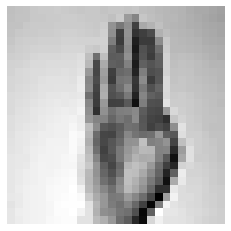

In [5]:
r = np.random.randint(0,27455)

if (r >= 0 and r < 27455):
    img = X[r].reshape((28, 28))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()  

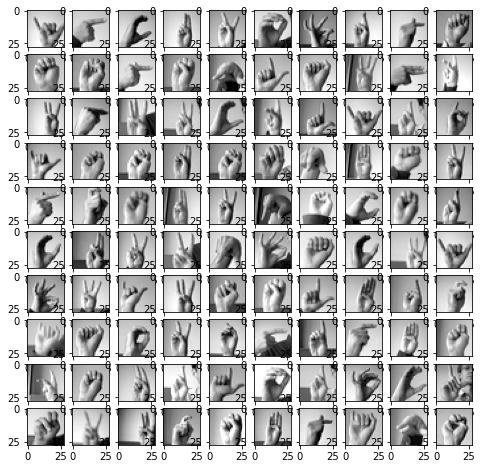

In [6]:
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        # Reshape back to 20x20 pixel image
        axis[i,j].imshow(X[np.random.randint(0,27455),:].reshape((28, 28)), cmap="gray") 

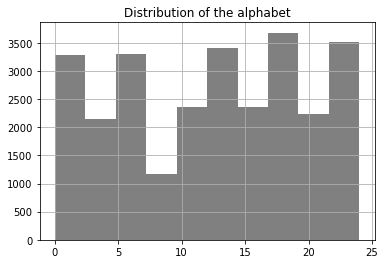

In [7]:
train.label.hist(color='grey',bins=10)
plt.title("Distribution of the alphabet")
plt.show()

# One-vs-All Classification

Here we implement one-vs-all classification by training multiple Regularized Logistic Regression classifiers, one for each of the K = 25 classes in the MNIST dataset.

It's worth noting that the implementation of algorithms like Logistic Regression in the scikit-learn library implements the OvR strategy (One-vs-Rest, also known as One-vs-All) by default when using these algorithms for multi-class classification.

In [8]:
# All parameters not specified are set to their defaults

# Penalty l2 stands for: Ridge Regression
# lbfgs stands for: "Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm"

# Higher max_iter to make sure the algorithm converges

logisticRegr = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
logisticRegr.fit(X, y)

predictions = logisticRegr.predict(X_test)
print("Predictions with testing data:", predictions)

Predictions with testing data: [ 6  5 10 ...  2  4  2]


## Measuring Model Performance

In [9]:
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.6919966536530954


In [10]:
cr = metrics.classification_report(y_test, predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       331
           1       1.00      0.91      0.95       432
           2       0.87      0.93      0.90       310
           3       0.90      0.86      0.88       245
           4       0.88      0.88      0.88       498
           5       0.72      0.91      0.80       247
           6       0.83      0.73      0.78       348
           7       0.81      0.71      0.75       436
           8       0.55      0.59      0.57       288
          10       0.67      0.41      0.51       331
          11       0.65      0.89      0.75       209
          12       0.71      0.62      0.66       394
          13       0.67      0.57      0.62       291
          14       0.99      0.63      0.77       246
          15       0.93      0.94      0.94       347
          16       0.61      0.74      0.67       164
          17       0.16      0.43      0.24       144
          18       0.33    

## Confusion Matrix

A confusion matrix is a table that is used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. In this section, we use Seaborn and Matplotlib to make confusion matrices more understandable and visually appealing.

In [11]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 391   0  20   0   0   0   0   0   2   0   0   0   0   0   0   0   0
    0  19   0   0   0   0]
 [  0   0 287   0   0  21   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   2   0   0   0]
 [  0   0   0 210   0   0   0   0   0   0   0   0   0   0   0   0  18   0
    0   0   0   0  17   0]
 [  0   0   0   0 438   0   0   0   0   0   0   0  18   0   0   0   0  42
    0   0   0   0   0   0]
 [  0   0  21   0   0 226   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 255  14   0   0   0   0   0   0   0  33   0   0
   40   0   0   0   6   0]
 [  0   0   0   0   0   0  42 308  15   0   0  21   0   0   0   0   0   0
   25  21   0   0   4   0]
 [  0   0   0   0   0   0   0  19 169  17   0   2  20   0   0   0  21   0
    0   0   0   0   0  40]
 [  0   0   0   0   0  21   0   0  17 137   0   3   0   0  19   0  78  21
    0  13   0  22

### Seaborn

Text(0.5, 1.0, 'Accuracy Score: 0.6919966536530954')

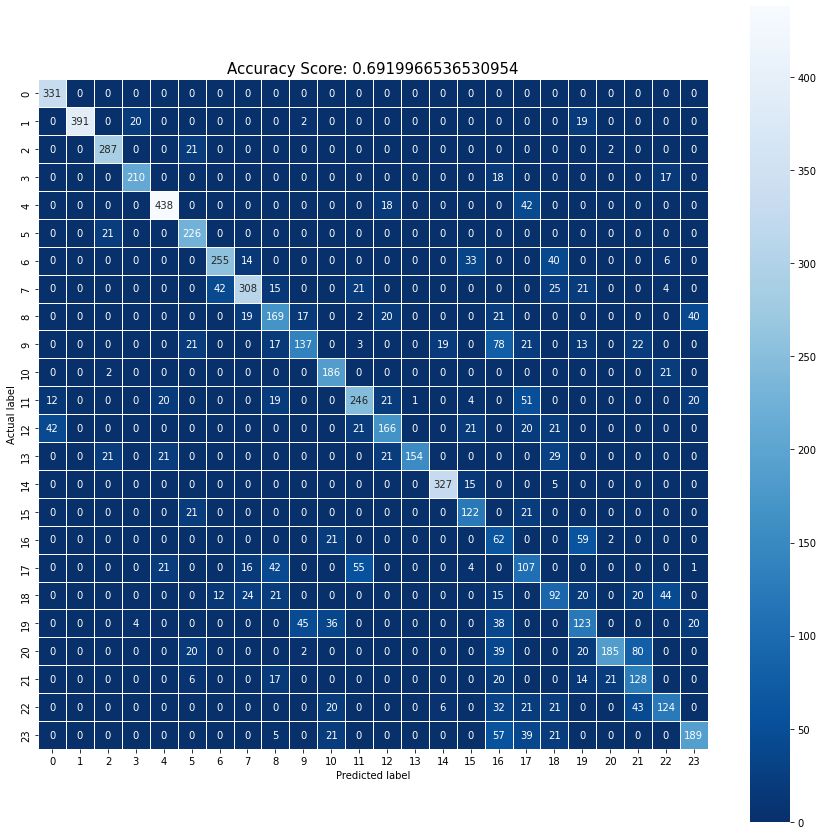

In [12]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

### Matplotlib

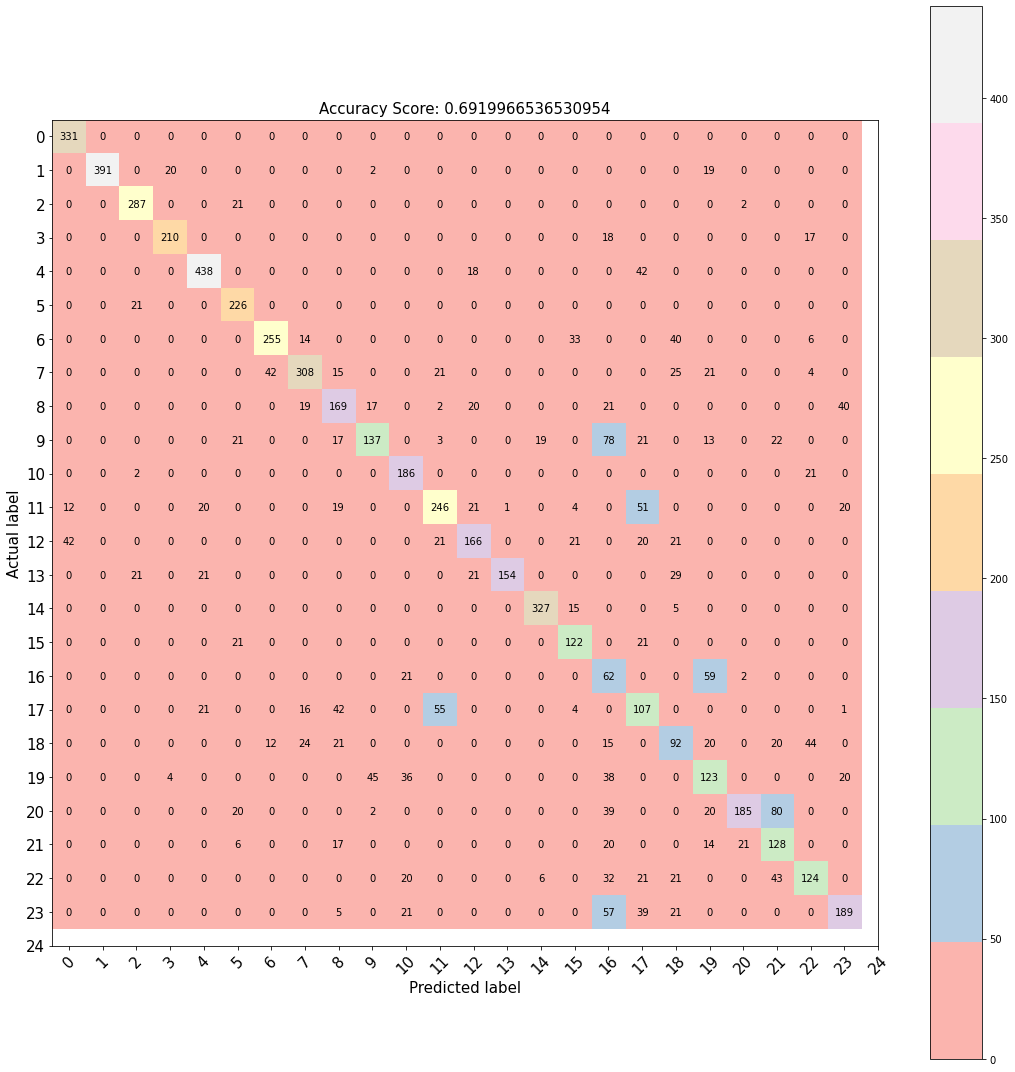

In [13]:
plt.figure(figsize=(15,15))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title(all_sample_title, size = 15)
plt.colorbar()
tick_marks = np.arange(25)
plt.xticks(tick_marks, rotation=45, size = 15)
plt.yticks(tick_marks, size = 15)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

## Display Misclassified images with Predicted Labels

In [14]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1

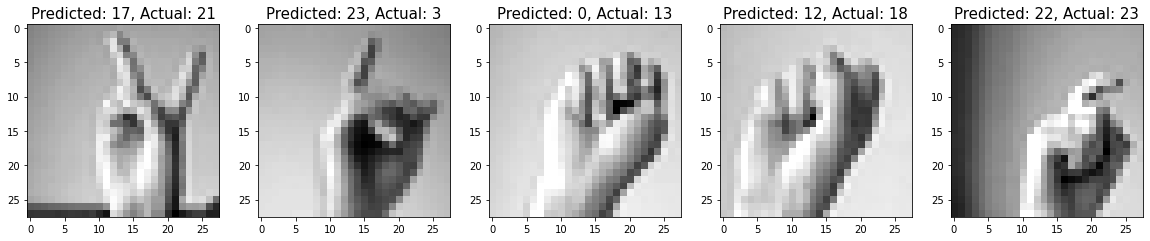

In [15]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_test[badIndex], (28,28)), cmap=plt.cm.gray)
    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], y_test[badIndex]), fontsize = 15)

# One-vs-All Classification with Stochastic Gradient Descent

Here we implement a regularized linear model like Logistic Regression with stochastic gradient descent (SGD) learning. SGDClassifier supports multi-class classification by combining multiple binary classifiers in a “one versus all” scheme.

The gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). Ideally, for best results using the default learning rate schedule, the data should have zero mean and unit variance.

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net).

In [16]:
X, y = load_train()

# Default alpha=0.0001
clf = SGDClassifier(loss="log", penalty="l2")
clf.fit(X, y)

SGDClassifier(loss='log')

## Measuring Model Performance

In [17]:
predictions = clf.predict(X_test)

score = metrics.accuracy_score(y_test, predictions)
print('Accuracy:', score)

Accuracy: 0.6426380368098159


In [18]:
cr = metrics.classification_report(y_test, predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       331
           1       0.99      0.85      0.91       432
           2       0.98      0.82      0.89       310
           3       0.87      0.79      0.83       245
           4       0.99      0.63      0.77       498
           5       0.39      0.91      0.55       247
           6       0.59      0.88      0.70       348
           7       0.93      0.65      0.76       436
           8       0.60      0.58      0.59       288
          10       0.59      0.30      0.40       331
          11       0.90      0.89      0.89       209
          12       0.58      0.72      0.64       394
          13       0.63      0.44      0.51       291
          14       1.00      0.45      0.62       246
          15       0.67      0.89      0.76       347
          16       0.58      0.74      0.65       164
          17       0.20      0.63      0.30       144
          18       0.38    

## Confusion Matrix

Text(0.5, 1.0, 'Accuracy Score: 0.6426380368098159')

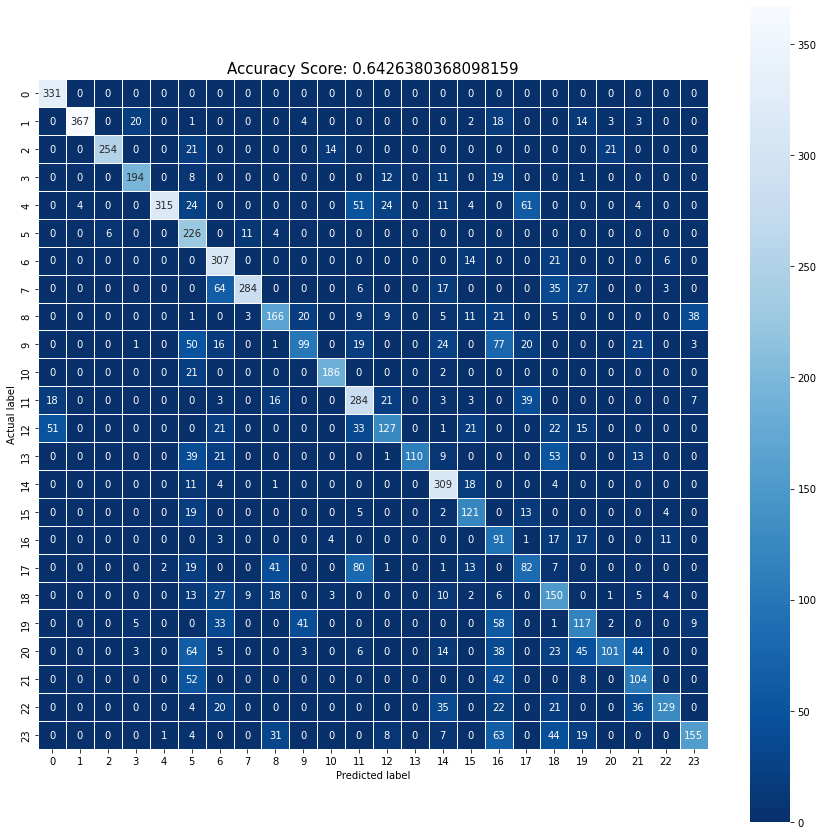

In [19]:
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

# K-Nearest-Neighbour

KNN is considered as an instance based learning or lazy learning. That is why it does not require as much time as other classification methods to be fitted and to predict. As for the k number of neighbours we chose 165, since that is the closest odd number to the squareroot of the training dataset size.

In [20]:
KNN = KNeighborsClassifier(n_neighbors=165)
classifier = KNN.fit(X, y)

## Measuring Model Performance

In [21]:
predictions = classifier.predict(X_test)

score = metrics.accuracy_score(y_test, predictions)
print('Accuracy:', score)

Accuracy: 0.6079196876742889


In [22]:
cr = metrics.classification_report(y_test, predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.63      0.97      0.77       331
           1       0.56      0.69      0.61       432
           2       0.84      0.98      0.90       310
           3       0.52      0.83      0.64       245
           4       0.80      0.82      0.81       498
           5       0.84      0.60      0.70       247
           6       0.62      0.78      0.69       348
           7       0.83      0.69      0.75       436
           8       0.59      0.58      0.58       288
          10       0.48      0.34      0.40       331
          11       0.97      0.65      0.78       209
          12       0.72      0.25      0.37       394
          13       0.39      0.34      0.36       291
          14       0.96      0.62      0.75       246
          15       0.94      0.97      0.95       347
          16       0.96      0.70      0.81       164
          17       0.09      0.15      0.11       144
          18       0.38    

## Confusion Matrix

Text(0.5, 1.0, 'Accuracy Score: 0.6079196876742889')

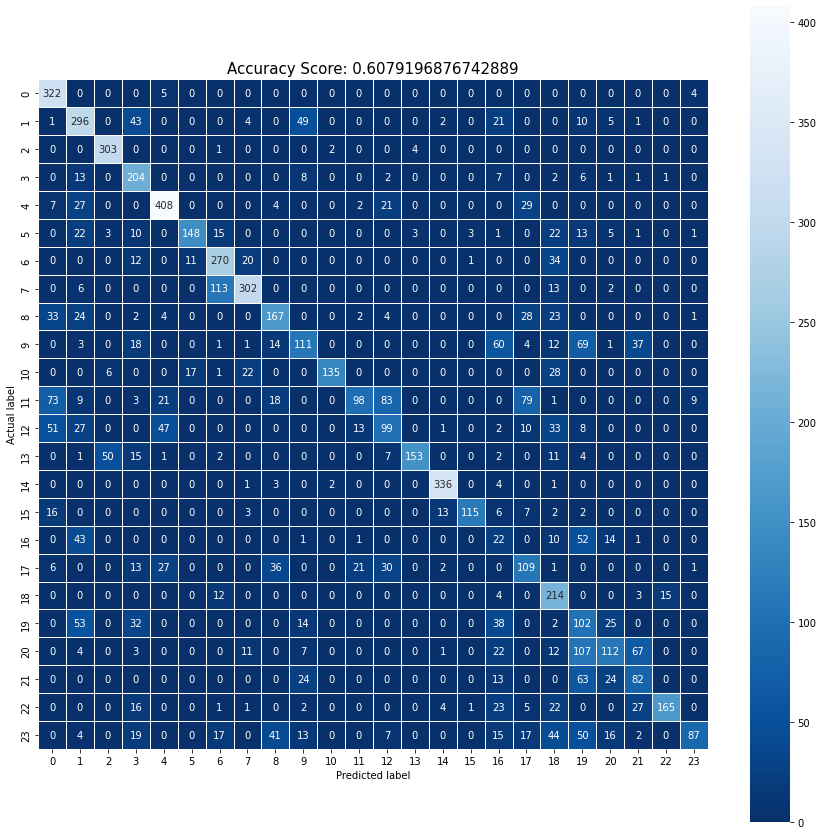

In [23]:
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

# Convolutional Neural Network

A convolution neural network is similar to a multi-layer perceptron network.The major differences are what the network learns, how they are structured and what purpose they are mostly used for. 

Convolutional neural networks were also inspired from biological processes, their structure has a semblance of the visual cortex present in an animal. CNNs are largely applied in the domain of computer vision and has been highly successful in achieving state of the art performance on various test cases.

The hidden layers in a CNN are generally convolution and pooling (downsampling) layers. In each convolution layer, we take a filter of a small size and move that filter across the image and perform convolution operations. Convolution operations are nothing but element-wise matrix multiplication between the filter values and the pixels in the image and the resultant values are summed.

## Prepare Data

Here we reshape the data because our CNN accepts only a four-dimensional vector. 

The value -1 represents the number of images in the training data, 28 represents the image size and 1 represents the number of channels. The number of channels is set to 1 if the image is in grayscale and if the image is in RGB format, the number of channels is set to 3. 

We also convert our target values into binary class matrices. To know what binary class matrices look like take a look at the example below:

Y = 2 # the value 2 represents that the image has label 2

Y = [0,0,1,0,0,0,0,0,0,0] # The 2nd position in the vector is made 1

In [24]:
X, y = load_train()
X_test, y_test = load_test()

batch_size = 32
num_classes = 25
epochs = 20

# Input image dimensions
img_rows, img_cols = 28, 28

# Reshaping the data from 1-D to 3-D as required through input by CNN's
X_reshaped = X.reshape(-1,28,28,1)
X_test_reshaped = X_test.reshape(-1,28,28,1)

# Convert class vectors to binary class matrices
y_class = np_utils.to_categorical(y, num_classes)
y_test_class = np_utils.to_categorical(y_test, num_classes)

## Build CNN 

A typical CNN model looks like this:
- Input layer
- Convolution layer + Activation function
- Pooling layer
- Fully Connected Layer

### First Attempt

Here we build a sequential model and add convolutional layers and max pooling layers to it.

We also add dropout layers in between: dropout randomly switches off some neurons in the network which forces the data to find new paths. Therefore, this reduces overfitting. We add dense layers at the end which are used for class prediction (0-25).

In [25]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

We now compile the model with a categorical cross entropy loss function, Adadelta optimizer and an accuracy metric. We then fit the dataset to the model, i.e we train the model for 20 epochs. 

The Adadelta optimizer, instead of summing up all the past squared gradients from 1 to “t” time steps, it restricts the window size. For example, it computes the squared gradient of the past 10 gradients and average out, solving the radically diminishing learning rates of other optimizers.

After training the model, we evaluate the loss and accuracy of the model on the test data and print it.

In [26]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [27]:
# EarlyStopping - Stop training when a monitored metric has stopped improving
# patience: Number of epochs with no improvement after which training will be stopped

history = model.fit(X_reshaped, y_class,
          batch_size=batch_size,
          epochs=epochs,
          validation_data = (X_test_reshaped, y_test_class),
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)],
          verbose=1)

Epoch 1/20
858/858 [==============================] - 31s 36ms/step - loss: 3.2229 - accuracy: 0.0407 - val_loss: 3.2108 - val_accuracy: 0.0619
Epoch 2/20
858/858 [==============================] - 31s 36ms/step - loss: 3.2178 - accuracy: 0.0427 - val_loss: 3.2082 - val_accuracy: 0.0644
Epoch 3/20
858/858 [==============================] - 33s 39ms/step - loss: 3.2147 - accuracy: 0.0406 - val_loss: 3.2059 - val_accuracy: 0.0650
Epoch 4/20
858/858 [==============================] - 30s 35ms/step - loss: 3.2091 - accuracy: 0.0467 - val_loss: 3.2040 - val_accuracy: 0.0482
Epoch 5/20
858/858 [==============================] - 31s 36ms/step - loss: 3.2087 - accuracy: 0.0444 - val_loss: 3.2022 - val_accuracy: 0.0368
Epoch 6/20
858/858 [==============================] - 31s 36ms/step - loss: 3.2060 - accuracy: 0.0453 - val_loss: 3.2005 - val_accuracy: 0.0381
Epoch 7/20
858/858 [==============================] - 30s 35ms/step - loss: 3.2034 - accuracy: 0.0448 - val_loss: 3.1991 - val_accuracy:

In [28]:
score = model.evaluate(X_test_reshaped, y_test_class, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.173198699951172
Test accuracy: 0.15393196046352386


The filter’s values are tuned through the iterative process of training and after a neural net has trained for certain number of epochs, these filters start to look out for various features in the image. 

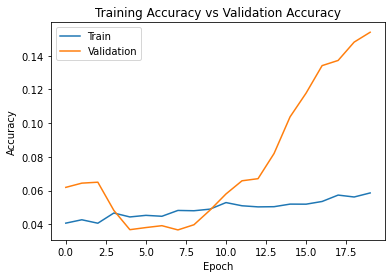

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

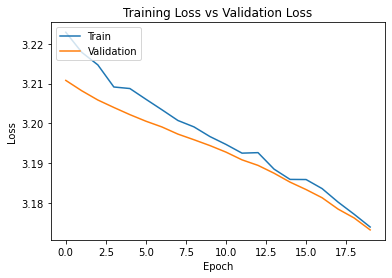

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Second Attempt

Here we try to improve the previous attempt by changing a couple of hidden layers and the optimizer used.

In [31]:
model = Sequential()
 
model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='softmax'))

Instead of using Adadelta optimizer, we use SGD with momentum. 

The problem with SGD is that while it tries to reach minima, because of the high oscillation, we can’t increase the learning rate. So it takes time to converge. With momentum, we use Exponentially Weighted Averages to compute Gradient and used this Gradient to update parameter.

In [32]:
learning_rate = 1e-3
lr_decay = 1e-6
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

In [33]:
history = model.fit(X_reshaped, y_class,
          batch_size=batch_size,
          epochs=epochs,
          validation_data = (X_test_reshaped, y_test_class),
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
          verbose=1)

Epoch 1/20
858/858 [==============================] - 94s 109ms/step - loss: 2.9058 - accuracy: 0.1401 - val_loss: 1.8749 - val_accuracy: 0.4721
Epoch 2/20
858/858 [==============================] - 87s 101ms/step - loss: 1.6840 - accuracy: 0.4663 - val_loss: 1.2299 - val_accuracy: 0.6166
Epoch 3/20
858/858 [==============================] - 88s 102ms/step - loss: 1.1726 - accuracy: 0.6102 - val_loss: 0.9166 - val_accuracy: 0.6984
Epoch 4/20
858/858 [==============================] - 88s 103ms/step - loss: 0.7808 - accuracy: 0.7364 - val_loss: 0.7158 - val_accuracy: 0.7598
Epoch 5/20
858/858 [==============================] - 88s 103ms/step - loss: 0.4630 - accuracy: 0.8426 - val_loss: 0.5409 - val_accuracy: 0.8337
Epoch 6/20
858/858 [==============================] - 94s 110ms/step - loss: 0.2823 - accuracy: 0.9041 - val_loss: 0.5495 - val_accuracy: 0.8470
Epoch 7/20
858/858 [==============================] - 111s 129ms/step - loss: 0.1935 - accuracy: 0.9324 - val_loss: 0.5432 - val_a

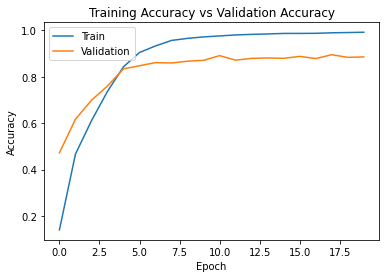

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

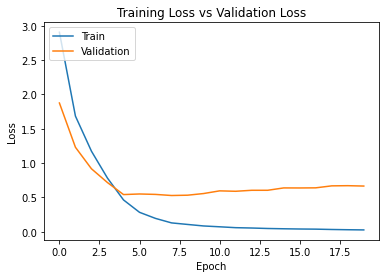

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Linear Support Vector Machine (C=1)

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection. They work by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable.

SVC implements the “one-versus-one” approach for multi-class classification. In total, n_classes * (n_classes - 1) / 2 classifiers are constructed and each one trains data from two classes. 

However, to provide a consistent interface with other classifiers, the decision_function_shape option allows to monotonically transform the results of the “one-versus-one” classifiers to a “one-vs-rest” decision function of shape (n_samples, n_classes). Later, we'll use this.

In [36]:
classifier = SVC(kernel="linear")
classifier.fit(X, y)

SVC(kernel='linear')

In [37]:
predictions = classifier.predict(X_test)

score = metrics.accuracy_score(y_test, predictions)
print('Accuracy:', score)

Accuracy: 0.7861126603457892


Text(0.5, 1.0, 'Accuracy Score: 0.7861126603457892')

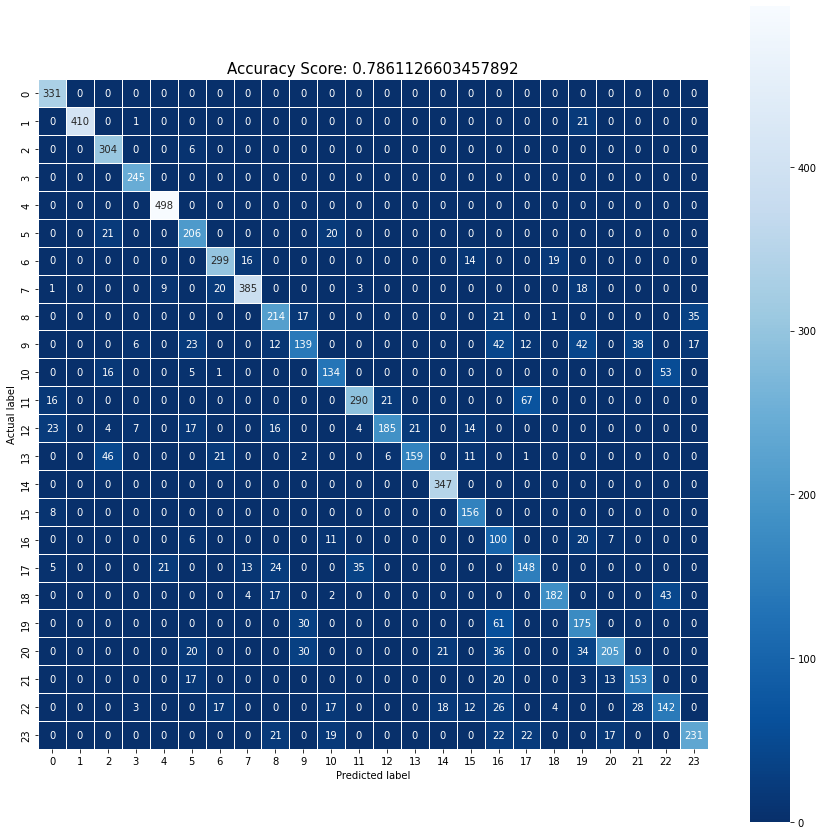

In [38]:
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

# Linear Support Vector Machine (C=10)

Here we specify the regularization parameter, C=10. The strength of the regularization is inversely proportional to C. The penalty is a squared l2 penalty.

In [39]:
classifier = SVC(C=10, kernel="linear")
classifier.fit(X, y)

SVC(C=10, kernel='linear')

In [40]:
predictions = classifier.predict(X_test)

score = metrics.accuracy_score(y_test, predictions)
print('Accuracy:', score)

Accuracy: 0.7816508644729504


Text(0.5, 1.0, 'Accuracy Score: 0.7816508644729504')

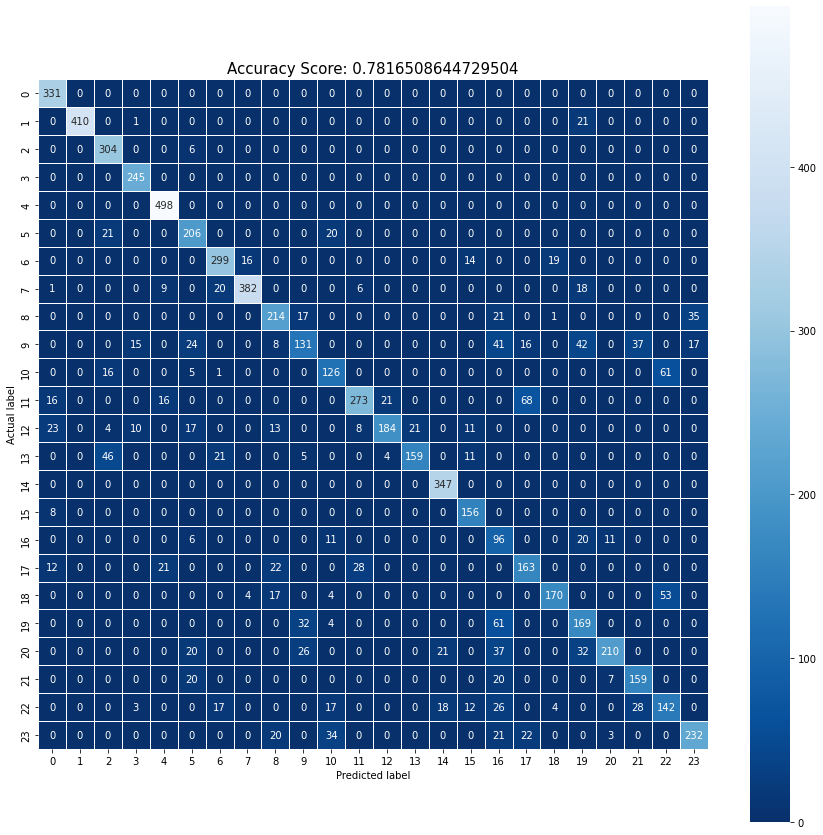

In [41]:
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

# One-vs-All with Support Vector Machine

Here we implement the Support Vector Machine algorithm, with One-vs-All decision function. We use all of our training data to estimate the parameters for our SVM model and afterwards validate it with the test dataset. The more data we use the more accurate our model will become.

In [42]:
classifier = SVC(decision_function_shape='ovr')
classifier.fit(X, y)

SVC()

## Measuring Model Performance

In [43]:
predictions = classifier.predict(X_test)

score = metrics.accuracy_score(y_test, predictions)
print('Accuracy:', score)

Accuracy: 0.8418851087562744


In [44]:
cr = metrics.classification_report(y_test, predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       331
           1       1.00      0.99      0.99       432
           2       0.88      0.99      0.93       310
           3       0.92      1.00      0.95       245
           4       0.94      0.99      0.97       498
           5       0.78      0.83      0.80       247
           6       0.93      0.93      0.93       348
           7       0.98      0.94      0.96       436
           8       0.80      0.90      0.85       288
          10       0.79      0.59      0.67       331
          11       0.87      1.00      0.93       209
          12       0.85      0.75      0.79       394
          13       0.90      0.68      0.78       291
          14       0.99      0.83      0.90       246
          15       1.00      1.00      1.00       347
          16       1.00      0.99      0.99       164
          17       0.28      0.54      0.37       144
          18       0.71    

## Confusion Matrix

Text(0.5, 1.0, 'Accuracy Score: 0.8418851087562744')

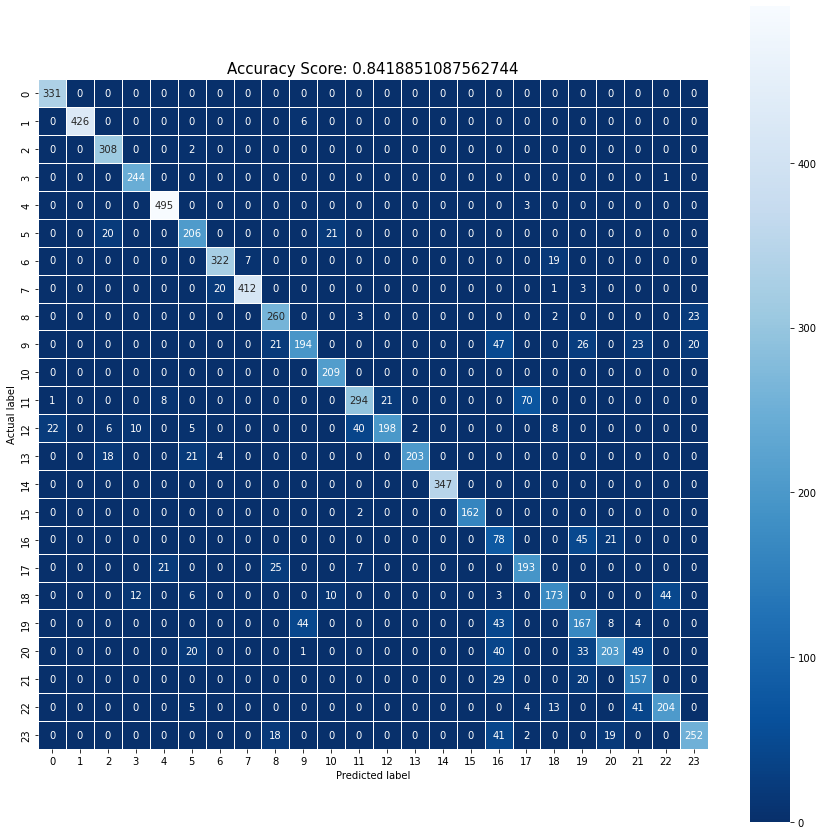

In [45]:
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

# References

Logistic Regression

https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

Sophastic Gradient Descent

https://docs.w3cub.com/scikit_learn/modules/sgd

https://towardsdatascience.com/deep-learning-optimizers-436171c9e23f

CNN

https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f

https://towardsdatascience.com/convolutional-neural-networks-explained-how-to-successfully-classify-images-in-python-df829d4ba761

https://pub.towardsai.net/convolutional-neural-networks-cnns-tutorial-with-python-417c29f0403f

https://keras.io/api/callbacks/early_stopping/